In [1]:
import os
import numpy as np
from ml_pi_predictor import ViscoelasticDataset, VE_TimeIntegrationPredictor
import torch
from pathlib import Path
from scipy.stats import pearsonr

# temporary solution:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # to avoid  OpenMP Conflicts
# OpenMP (Open Multi-Processing) is a parallel computing API
# used to speed up computations by running code on multiple CPU cores simultaneously.
import matplotlib.pyplot as plt


In [2]:
# Define data directory

data_root_dir = Path(os.path.expanduser("~")) / "bmcs_training_data"
new_data_root_dir = Path(os.path.expanduser("~")) / "bmcs_validating_data"
dataset = ViscoelasticDataset(data_root_dir, normalize=True)


Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.1A\Pi_data_10C_0.1A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.2A\Pi_data_10C_0.2A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.3A\Pi_data_10C_0.3A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.4A\Pi_data_10C_0.4A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.5A\Pi_data_10C_0.5A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.6A\Pi_data_10C_0.6A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.7A\Pi_data_10C_0.7A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.8A\Pi_data_10C_0.8A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.9A\Pi_data_10C_0.9A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_1.0A\Pi_data_10C_1.0A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_1.1A\Pi_data_10C_1.1A.npy
Loading data from: C:

In [3]:
sample_data_1_path = Path("C:/Users/A_structure/bmcs_validating_data/HHLL_4C_1A_20S/Pi_data_HHLL_4C_1A_20S.npy")
sample_data_2_path = Path("C:/Users/A_structure/bmcs_validating_data/2.5C_1.45A_40S/Pi_data_2.5C_1.45A_40S.npy")
sample_data_1 = np.load(sample_data_1_path)
sample_data_2 = np.load(sample_data_2_path)


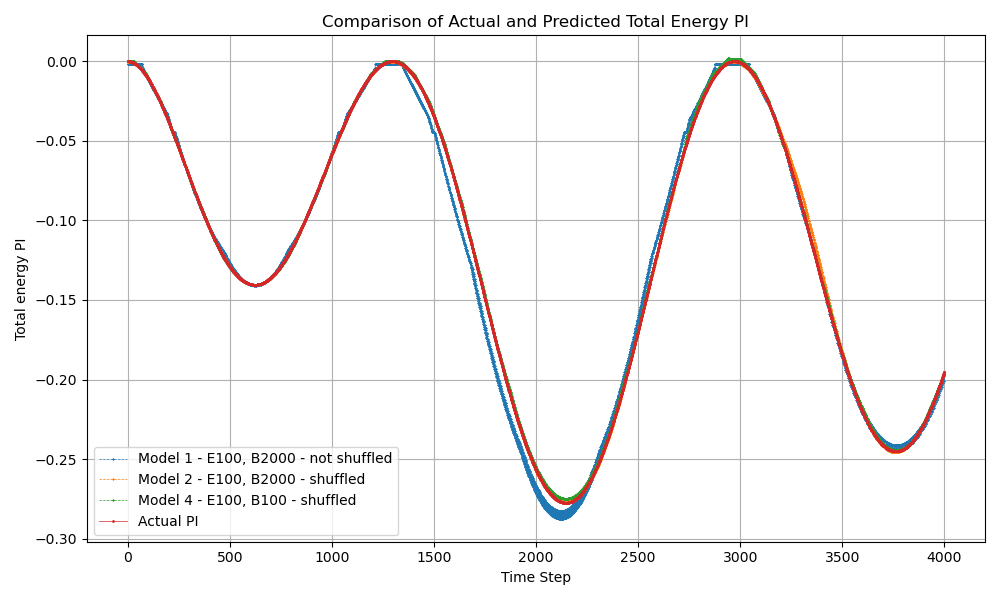

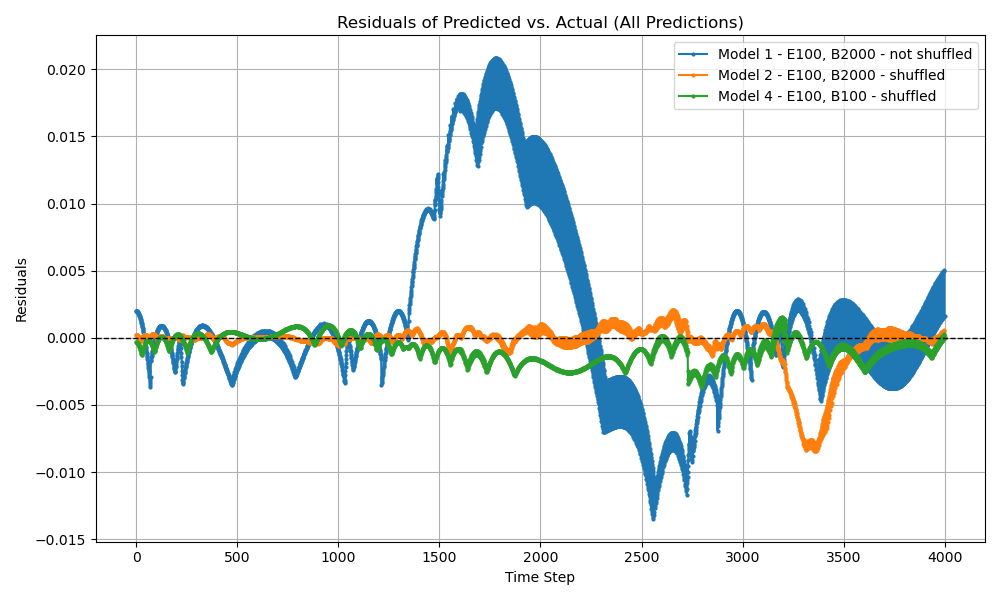

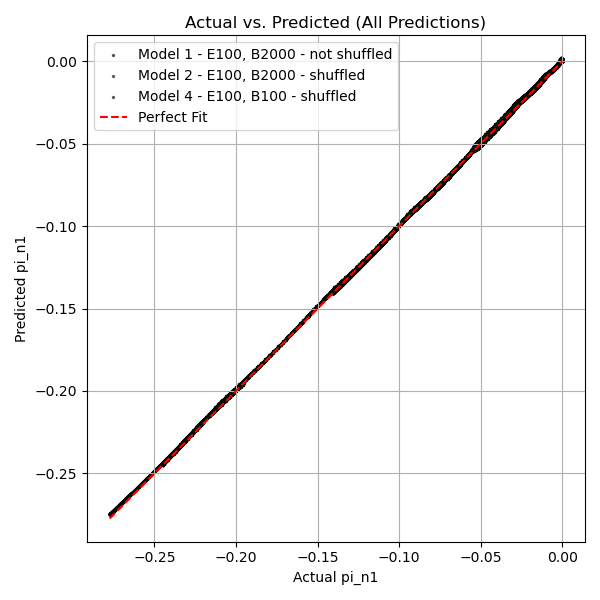


📊 Metrics for Model 1 - E100, B2000 - not shuffled:
  MSE: 0.000049
  RMSE: 0.007018
  MAE: 0.004613
  R²: 0.993763
  Pearson Correlation: 0.997146

📊 Metrics for Model 2 - E100, B2000 - shuffled:
  MSE: 0.000003
  RMSE: 0.001670
  MAE: 0.000761
  R²: 0.999647
  Pearson Correlation: 0.999830

📊 Metrics for Model 4 - E100, B100 - shuffled:
  MSE: 0.000002
  RMSE: 0.001279
  MAE: 0.001025
  R²: 0.999793
  Pearson Correlation: 0.999949


In [ ]:
%matplotlib widget
# ---------- Load and Normalize Data ----------
sample_data = sample_data_2
eps_t, dd_eps_t, eps_v_t, d_t, pi_n1 = sample_data.T
input_vectors = np.column_stack([eps_t, dd_eps_t, eps_v_t, d_t])
mean, std = dataset.mean, dataset.std
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Model Configurations ----------
model_configs = {
    "Model 1 - E100, B2000 - not shuffled": "ve_pi_p_e100_b2000_false_.pth",
    "Model 2 - E100, B2000 - shuffled": "ve_pi_p_e100_b2000_true_.pth",
    # "Model 3 - E100, B100 - not shuffled": "ve_pi_p_e100_b100_false_.pth",
    "Model 4 - E100, B100 - shuffled": "ve_pi_p_e100_b100_true_.pth",
    # Add more models here as needed
}

# ---------- Functions ----------
def load_model(path):
    model = VE_TimeIntegrationPredictor().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

def predict_with_model(model, inputs, mean, std):
    predictions = []
    with torch.no_grad():
        for vec in inputs:
            norm_vec = (vec - mean) / std
            input_tensor = torch.tensor(norm_vec, dtype=torch.float32).to(device)
            prediction = model(input_tensor).cpu().numpy().flatten()[0]
            predictions.append(prediction)
    return np.array(predictions)

# ---------- Run Predictions ----------
all_predictions = {}
for label, model_path in model_configs.items():
    model = load_model(model_path)
    preds = predict_with_model(model, input_vectors, mean, std)
    all_predictions[label] = preds

# ---------- Plot: Actual vs Predicted Time Series ----------
plt.figure(figsize=(10, 6))
for label, preds in all_predictions.items():
    plt.plot(preds , label=label, linestyle='--', marker='x', markersize=1, linewidth=0.5)
plt.plot(pi_n1, label='Actual PI', linestyle='-', marker='o', markersize=1, linewidth=0.5)

plt.xlabel("Time Step")
plt.ylabel("Total energy PI")
plt.legend()
plt.title("Comparison of Actual and Predicted Total Energy PI")
plt.grid()
plt.tight_layout()
plt.show()

# ---------- Plot: Residuals ----------
plt.figure(figsize=(10, 6))
for label, preds in all_predictions.items():
    residuals = pi_n1 - preds
    plt.plot(residuals, label=label, marker='o', markersize=2, linestyle='-')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Time Step")
plt.ylabel("Residuals")
plt.title("Residuals of Predicted vs. Actual (All Predictions)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ---------- Plot: Scatter Actual vs Predicted ----------
plt.figure(figsize=(6, 6))
for label, b in all_predictions.items():
    plt.scatter(pi_n1, preds, label=label, alpha=0.6, s=2, edgecolors='k')
plt.plot([min(pi_n1), max(pi_n1)], [min(pi_n1), max(pi_n1)], 'r--', label='Perfect Fit')
plt.xlabel("Actual pi_n1")
plt.ylabel("Predicted pi_n1")
plt.title("Actual vs. Predicted (All Predictions)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ---------- Compute and Print Metrics ----------
for i, (label, preds) in enumerate(all_predictions.items(), start=1):
    mse = np.mean((pi_n1 - preds) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(pi_n1 - preds))
    ss_total = np.sum((pi_n1 - np.mean(pi_n1)) ** 2)
    ss_residual = np.sum((pi_n1 - preds) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    pearson_corr, _ = pearsonr(pi_n1, preds)

    print(f'\n📊 Metrics for {label}:')
    print(f'  MSE: {mse:.6f}')
    print(f'  RMSE: {rmse:.6f}')
    print(f'  MAE: {mae:.6f}')
    print(f'  R²: {r2:.6f}')
    print(f'  Pearson Correlation: {pearson_corr:.6f}')
